
# 小地域の収入推定

```Data```フォルダには、小地域の収入データ(```income_district.csv```)と国勢調査の小地域集計データが格納されています。

国勢調査の小地域集計データ（人口構成、労働力構成、住宅形態など）から、その地域の収入を推定することが考えられます。推定のための機械学習・深層学習モデルを構築しなさい。


- データを観察・理解する上で、データの構造を説明しながら、適切なデータ整形を行いなさい
- データ構造や分析結果に対して、少なくとも二つの図で可視化を行いなさい
- モデルの精度を評価し、できるだけ精度が高いモデルを得るよう、適切な特徴量エンジニアリングやモデル選定の考えもまとめなさい


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 读取所需的csv文件
gender_data = pd.read_csv('./h27_gender_df2.csv', encoding='utf-8')
labor_data = pd.read_csv('./h27_labor_df.csv', encoding='utf-8')
work_status_data = pd.read_csv('./h27_work_status_df.csv', encoding='utf-8')
income_data = pd.read_csv('./income_district.csv', encoding='utf-8')

# 将gender、labor和work_status横向合并
data_attribute = pd.merge(gender_data, labor_data, on=['district_id', 'district2_id', 'level_identifier'])
data_attribute = pd.merge(data_attribute, work_status_data, on=['district_id', 'district2_id', 'level_identifier'])

# 将合并产生的重复列去除
data_attribute.drop(['state_name_x', 'city_name_x', 'district_name_x', 'district2_name_x', 'state_name_y', 'city_name_y', 'district_name_y', 'district2_name_y'], axis=1, inplace=True)

# 将需要的属性列的缺失值替换为0
data_attribute = data_attribute.replace({'-': 0, 'X': 0})

# 筛选出level_identifier为1的数据行
data_attribute = data_attribute[data_attribute['level_identifier'] == 1]
data_attribute = data_attribute.reset_index()

# 将收入数据合并进来，并去除没有匹配收入数据的行
data_attribute = pd.merge(data_attribute, income_data, left_on='district_id', right_on='area_code')
data_attribute = data_attribute[data_attribute['income_mean'] != np.nan]

# 将训练模型需要的数据列挑出来接下来用于模型拟合
data_use = data_attribute[['district_id', 'population', 'male_population', 'female_population', 'family_count', 'labor_male', 'no_labor_male', 'labor_female', 'no_labor_female', 'employer_male',
                          'self_employed_male', 'family_work_male', 'unkonwn_status_male', 'employer_female', 'self_employed_female', 'family_work_female', 'unkonwn_status_female', 'income_mean']]
# 打印data_use的列属性个和数值类型并查看data_use
print(data_use.dtypes)
print(data_use)

district_id                int64
population                object
male_population           object
female_population         object
family_count              object
labor_male                object
no_labor_male             object
labor_female              object
no_labor_female           object
employer_male             object
self_employed_male        object
family_work_male          object
unkonwn_status_male       object
employer_female           object
self_employed_female      object
family_work_female        object
unkonwn_status_female     object
income_mean              float64
dtype: object
      district_id population male_population female_population family_count  \
0           18201     265904          128892            137012        99872   
1           18202      66165           32558             33607        26545   
2           18204      29670           14539             15131        11220   
3           18205      33109           15683             17426        10698 

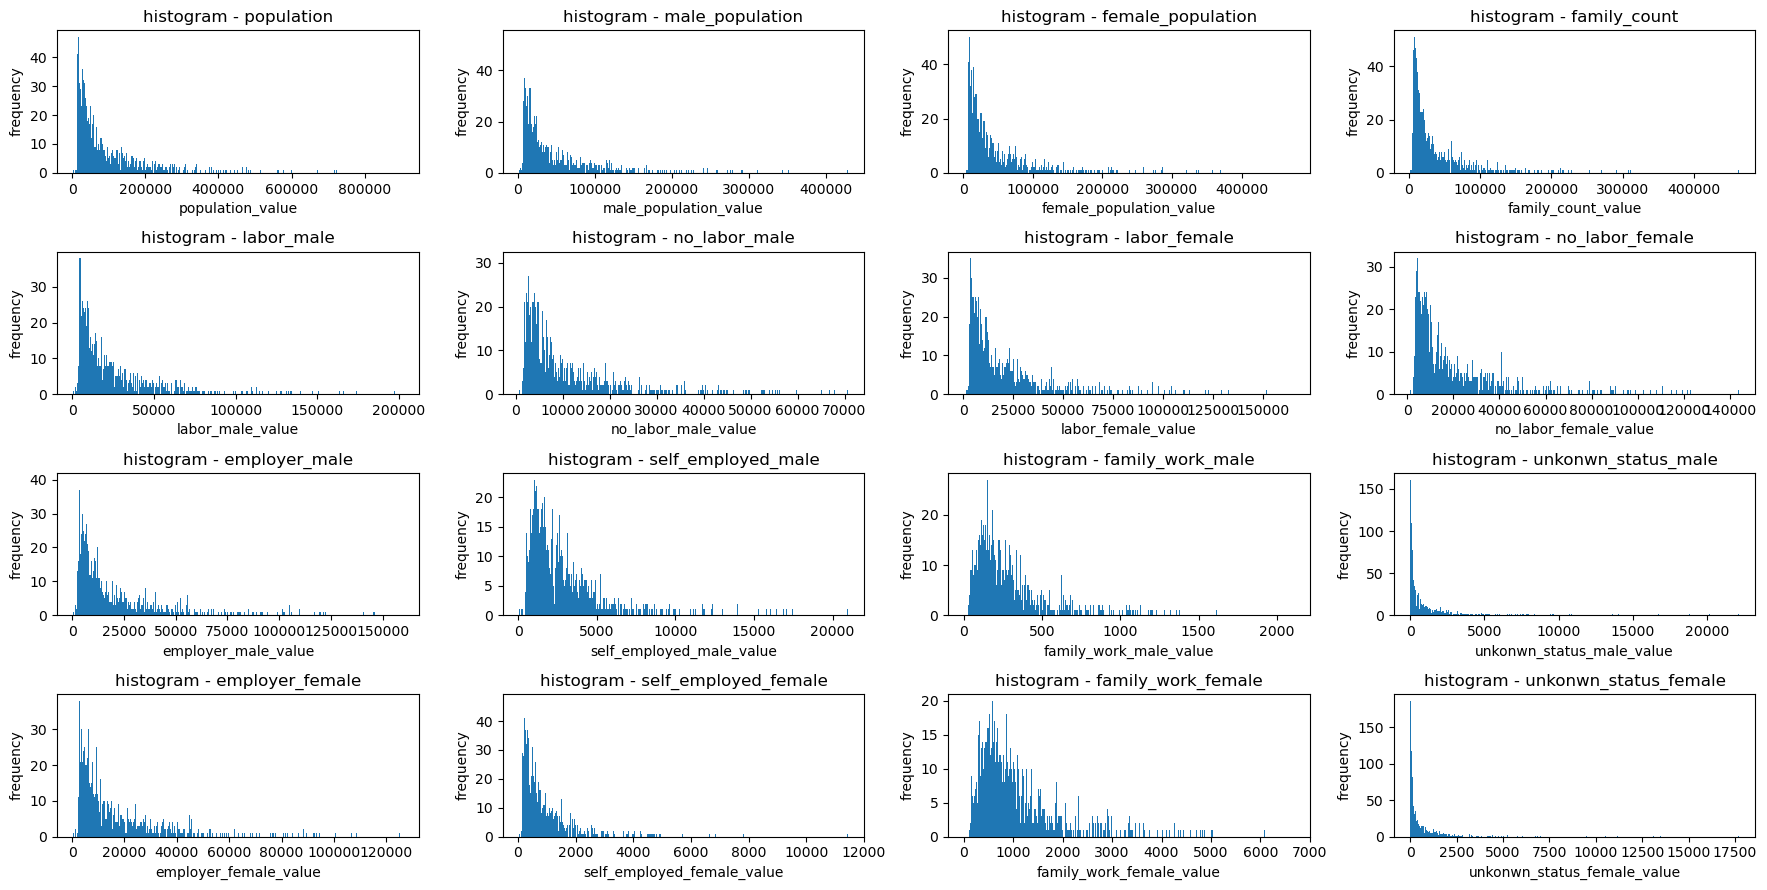

In [14]:
# 然后进行数据的可视化，这里绘制各个属性的直方图
data_figure = data_use.drop(['district_id', 'income_mean'], axis=1).copy()
fig, axs = plt.subplots(4, 4, figsize=(18, 9))

# 遍历每一列并绘制直方图
for i, column in enumerate(data_figure.columns):
    row = i // 4
    col = i % 4
    # 在当前子图上绘制直方图
    axs[row, col].hist(data_figure[column].astype(int), bins=500)  # 设置 bins 为需要的箱子数量
    # 设置当前子图的标签和标题
    axs[row, col].set_xlabel(f'{column}'+'_value')  # 设置横轴标签
    axs[row, col].set_ylabel('frequency')  # 设置纵轴标签
    axs[row, col].set_title(f'histogram - {column}')  # 设置标题
plt.tight_layout()  # 设置紧凑子图，防止子图重叠
plt.show()
plt.close()

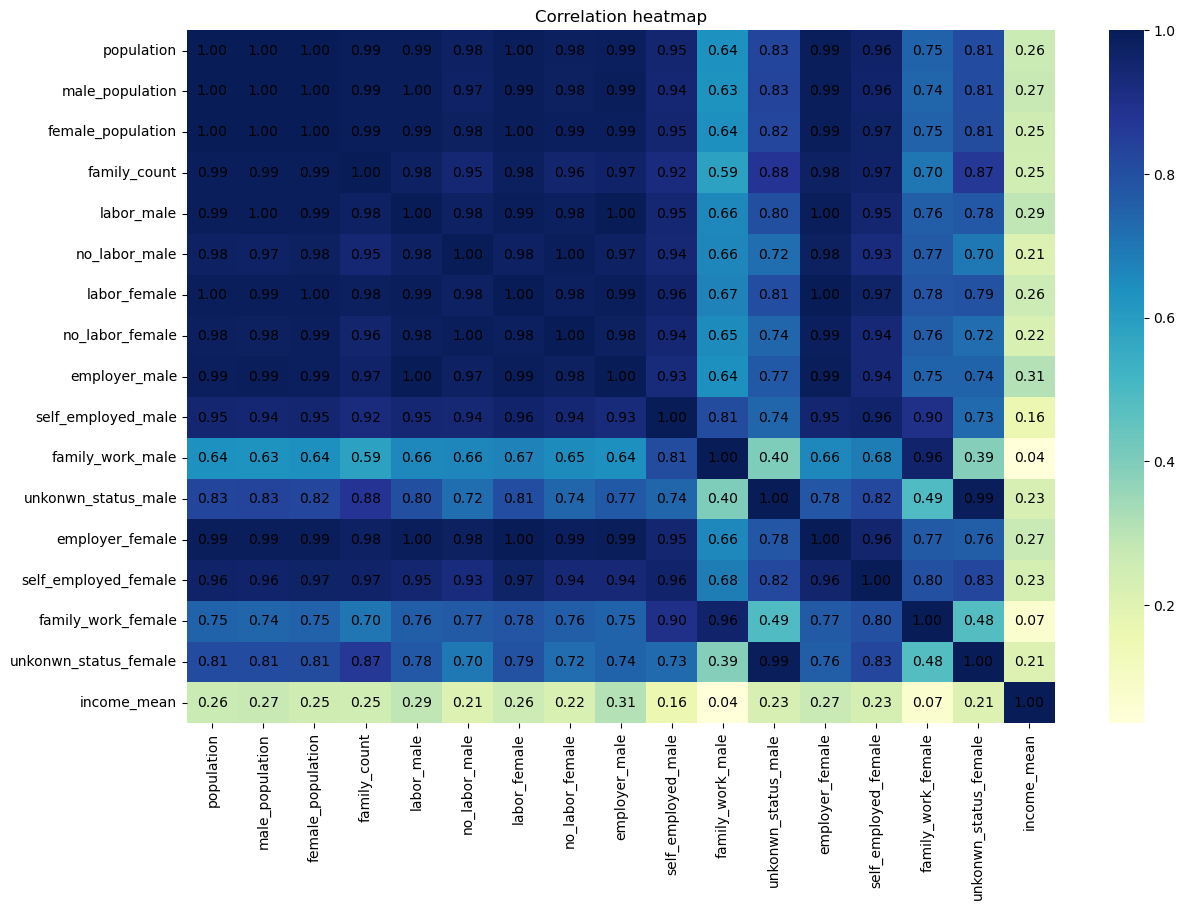

In [15]:
# 接下来绘制数据之间的相关性热力图
figure2 = plt.figure(figsize=(14, 9))
data_figure2 = data_use.drop(['district_id'], axis=1).copy()
# 计算属性之间的相关性
data_corr = data_figure2.corr()
# 使用Seaborn绘制相关性热力图

# 添加文本标签
for i in range(len(data_corr)):
    for j in range(len(data_corr)):
        text = f"{data_corr.iloc[i, j]:.2f}"
        plt.text(j + 0.5, i + 0.5, text, ha='center', va='center')
        
sns.heatmap(data_corr, annot=False, cmap='YlGnBu')
plt.title('Correlation heatmap')
plt.show()
plt.close()

In [16]:
# 接下来划分数据为训练集和测试集，设置测试集比例为0.2
X = data_use.drop(['district_id', 'income_mean', 'self_employed_male', 'family_work_male', 'family_work_female'], axis=1).copy()
y = data_use['income_mean']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

# 树的个数设置为50
rf_model = RandomForestRegressor(n_estimators=50, max_depth=5)
rf_model.fit(X_train, y_train)


# score 得分 计算的是模型的R方值
print("训练集得分:{},测试集得分:{}".format(rf_model.score(X_train, y_train), rf_model.score(X_test, y_test)))

# 模型评估
from sklearn.metrics import explained_variance_score, r2_score

y_pred = rf_model.predict(X_test)
print('随机森林回归模型的可解释方差值为：', explained_variance_score(y_test, y_pred))

训练集得分:0.534020663704289,测试集得分:0.3916879247870966
随机森林回归模型的可解释方差值为： 0.3926646429452112


In [17]:
# 创建随机森林回归模型
rf = RandomForestRegressor()
# 定义参数网格
param_grid = {
    'n_estimators': [100, 125, 150, 200],
    'max_depth': [2, 6, 10],
    'min_samples_split': [2, 5, 10],
    'max_features': [2, 4, 6, 8, 10]
}
# 创建GridSearchCV对象
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1)
# 在训练集上进行网格搜索
grid_search.fit(X_train, y_train)
# 输出最优参数组合
print("最优参数组合：", grid_search.best_params_)
# 在测试集上评估模型性能
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)
accuracy = r2_score(y_test, y_pred)
print("最优模型的准确率：", accuracy)

最优参数组合： {'max_depth': 10, 'max_features': 10, 'min_samples_split': 5, 'n_estimators': 150}
最优模型的准确率： 0.5278262937949469
